<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L12-DeepLearning_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning using keras

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Valerio Maggio](https://mpba.fbk.eu), Fondazione Bruno Kessler, [Alejandro Correa Bahnsen](albahnsen.com/) and [Jesus Solano](https://github.com/jesugome)

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysisClass/68b4cc50f2cba5e389d7fa75afe7a5e658c38086/notebooks/images/keras-logo-small.jpg" width="20%" />

## Keras: Deep Learning library for Theano and TensorFlow

>Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano.

>It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
ref: https://keras.io/

### SMS Spam Collection Data

##### For this section we will use the SMS Spam Collection. This is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

# Single Layer Neural Network


## Data Preparation

In [ ]:
!pip install wget
!pip install livelossplot --quiet

In [ ]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import Embedding
from keras.utils import pad_sequences
from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2023-08-26 04:09:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [  <=>               ] 198.65K   980KB/s    in 0.2s    

2023-08-26 04:09:24 (980 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X = X.apply(preprocess)

### Create vocabulary

In [ ]:
X = X.tolist()

In [ ]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

### Create Embedding

In [ ]:
# Max len
max_len = 150
X = [x[:max_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [ ]:
len(X)

5572

In [ ]:
X_pad = pad_sequences(X, maxlen=max_len)

In [ ]:
X_pad

array([[ 0,  0,  0, ..., 24, 22, 37],
       [ 0,  0,  0, ..., 43,  2, 26],
       [ 0,  0,  0, ..., 33,  3, 11],
       ...,
       [ 0,  0,  0, ..., 43,  2, 11],
       [ 0,  0,  0, ...,  4,  5,  5],
       [ 0,  0,  0, ..., 22, 17,  5]], dtype=int32)

In [ ]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, stratify = df['target'], test_size = 0.3, random_state = 18)

---

# Using Keras

In [ ]:
learning_rate = 0.01

In [ ]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          7680      
                                                                 
 dense_1 (Dense)             (None, 150, 1)            129       
                                                                 
Total params: 7,809
Trainable params: 7,809
Non-trainable params: 0
_________________________________________________________________


### Be more specific with hyperparameters...

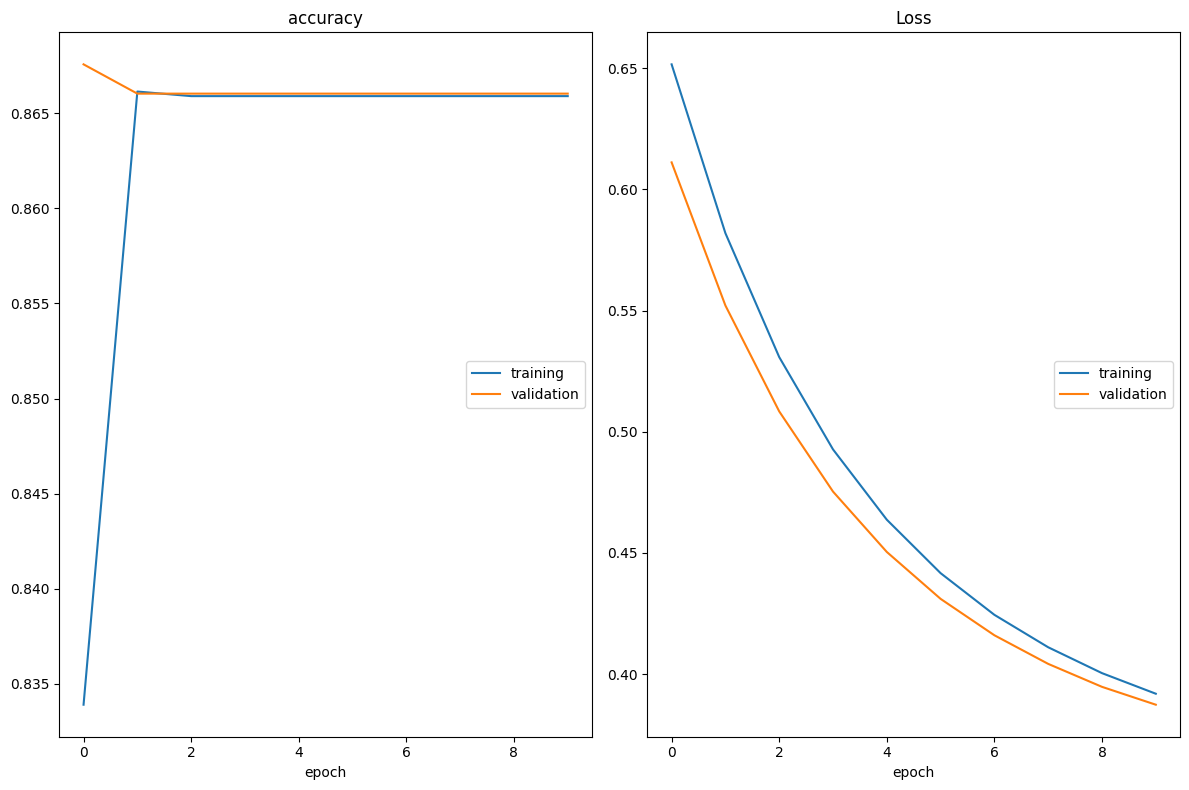

accuracy
	training         	 (min:    0.834, max:    0.866, cur:    0.866)
	validation       	 (min:    0.866, max:    0.868, cur:    0.866)
Loss
	training         	 (min:    0.392, max:    0.652, cur:    0.392)
	validation       	 (min:    0.387, max:    0.611, cur:    0.387)
31/31 [==============================] - 1s 35ms/step - loss: 0.3919 - accuracy: 0.8659 - val_loss: 0.3873 - val_accuracy: 0.8660


In [ ]:
import keras.optimizers as opts

K.clear_session()

model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))
model.add(Dense(1, activation='sigmoid'))

op = opts.SGD(lr=learning_rate)

model.compile(loss='binary_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=[X_test, y_test],
          batch_size=128, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

Simplicity is pretty impressive right? :)

Now lets understand:
<pre>The core data structure of Keras is a <b>model</b>, a way to organize layers. The main type of model is the <b>Sequential</b> model, a linear stack of layers.</pre>


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

##### Dense

```python
from keras.layers.core import Dense

Dense(units, activation=None, use_bias=True,
      kernel_initializer='glorot_uniform', bias_initializer='zeros',
      kernel_regularizer=None, bias_regularizer=None,
      activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
```

* `units`: int > 0.

* `init`: name of initialization function for the weights of the layer (see initializations), or alternatively, Theano function to use for weights initialization. This parameter is only relevant if you don't pass a weights argument.

* `activation`: name of activation function to use (see activations), or alternatively, elementwise Theano function. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

* `weights`: list of Numpy arrays to set as initial weights. The list should have 2 elements, of shape (input_dim, output_dim) and (output_dim,) for weights and biases respectively.

* `kernel_regularizer`: instance of WeightRegularizer (eg. L1 or L2 regularization), applied to the main weights matrix.

* `bias_regularizer`: instance of WeightRegularizer, applied to the bias.

* `activity_regularizer`: instance of ActivityRegularizer, applied to the network output.

* `kernel_constraint`: instance of the constraints module (eg. maxnorm, nonneg), applied to the main weights matrix.

* `bias_constraint`: instance of the constraints module, applied to the bias.

* `use_bias`: whether to include a bias (i.e. make the layer affine rather than linear).

## (some) others `keras.core.layers`

* `keras.layers.core.Flatten()`
* `keras.layers.core.Reshape(target_shape)`
* `keras.layers.core.Permute(dims)`

```python
model = Sequential()
model.add(Permute((2, 1), input_shape=(10, 64)))
# now: model.output_shape == (None, 64, 10)
# note: `None` is the batch dimension
```

* `keras.layers.core.Lambda(function, output_shape=None, arguments=None)`
* `keras.layers.core.ActivityRegularization(l1=0.0, l2=0.0)`

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysisClass/68b4cc50f2cba5e389d7fa75afe7a5e658c38086/notebooks/images/dl_overview.png" >

Credits: Yam Peleg ([@Yampeleg](https://twitter.com/yampeleg))

##### Activation

```python
from keras.layers.core import Activation

Activation(activation)
```

**Supported Activations** : [https://keras.io/activations/]

**Advanced Activations**: [https://keras.io/layers/advanced-activations/]

##### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
Here we used <b>SGD</b> (stochastic gradient descent) as an optimization algorithm for our trainable weights.  

<img src="http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif" width="40%">

Source & Reference: http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif

"Data Sciencing" this example a little bit more
=====

What we did here is nice, however in the real world it is not useable because of overfitting.
Lets try and solve it with cross validation.

##### Overfitting

In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is excessively complex, such as having too many parameters relative to the number of observations.

A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.


<img src="https://raw.githubusercontent.com/leriomaggio/deep-learning-keras-tensorflow/master/imgs/overfitting.png">

<pre>To avoid overfitting, we will first split out data to training set and test set and test out model on the test set.
Next: we will use two of keras's callbacks <b>EarlyStopping</b> and <b>ModelCheckpoint</b></pre>

---

Let's see first the model we implemented

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          7680      
                                                                 
 dense (Dense)               (None, 150, 1)            129       
                                                                 
Total params: 7,809
Trainable params: 7,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

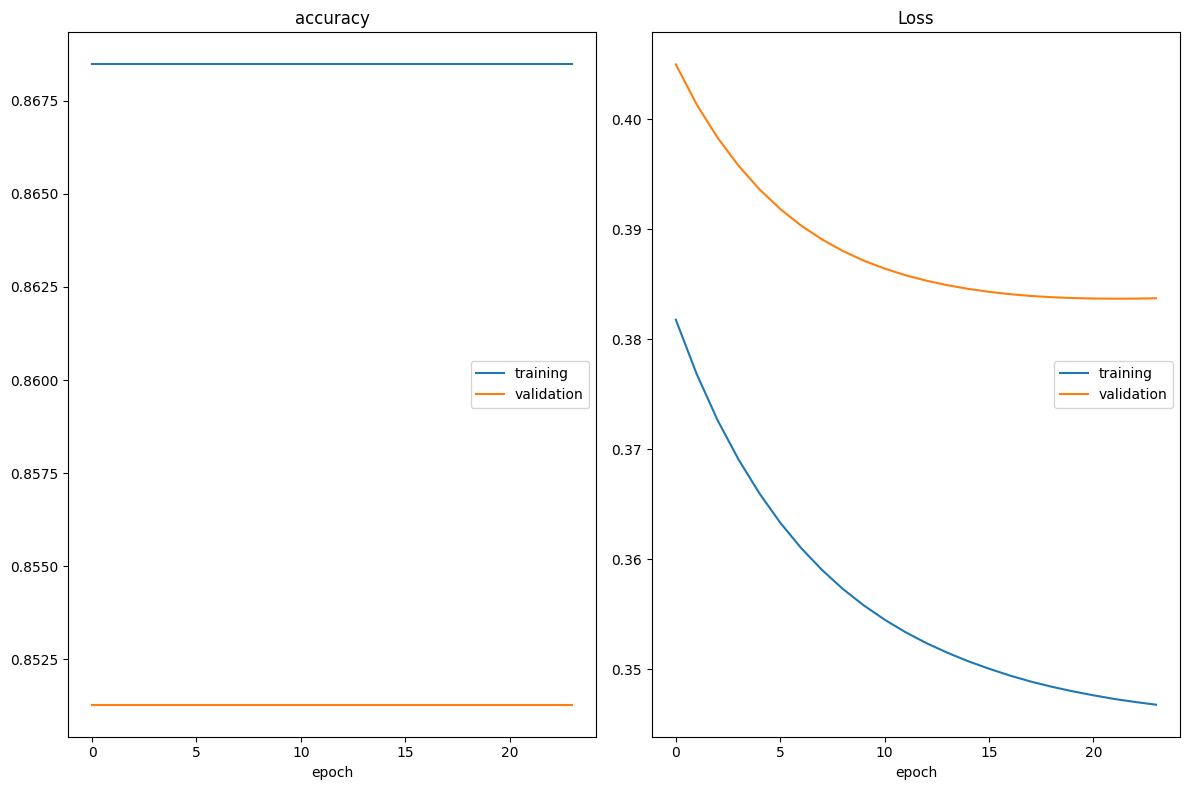

accuracy
	training         	 (min:    0.868, max:    0.868, cur:    0.868)
	validation       	 (min:    0.851, max:    0.851, cur:    0.851)
Loss
	training         	 (min:    0.347, max:    0.382, cur:    0.347)
	validation       	 (min:    0.384, max:    0.405, cur:    0.384)
26/26 [==============================] - 1s 58ms/step - loss: 0.3468 - accuracy: 0.8685 - val_loss: 0.3837 - val_accuracy: 0.8513
Epoch 24: early stopping


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

fBestModel = 'best_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=50,
          batch_size=128, verbose=True, callbacks=[best_model, early_stop, PlotLossesKeras()])

# Multi-Layer Fully Connected Networks

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysisClass/68b4cc50f2cba5e389d7fa75afe7a5e658c38086/notebooks/images/MLP.png" width="65%">

#### Forward and Backward Propagation

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysisClass/68b4cc50f2cba5e389d7fa75afe7a5e658c38086/notebooks/images/backprop.png" width="80%">

**Q:** _How hard can it be to build a Multi-Layer Fully-Connected Network with keras?_

**A:** _It is basically the same, just add more layers!_

In [ ]:
K.clear_session()
print("Building model...")
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()

Building model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          7680      
                                                                 
 dense (Dense)               (None, 150, 256)          33024     
                                                                 
 dense_1 (Dense)             (None, 150, 128)          32896     
                                                                 
 dense_2 (Dense)             (None, 150, 64)           8256      
                                                                 
 dense_3 (Dense)             (None, 150, 1)            65        
                                                                 
Total params: 81,921
Trainable params: 81,921
Non-trainable params: 0
_________________________________________________________________


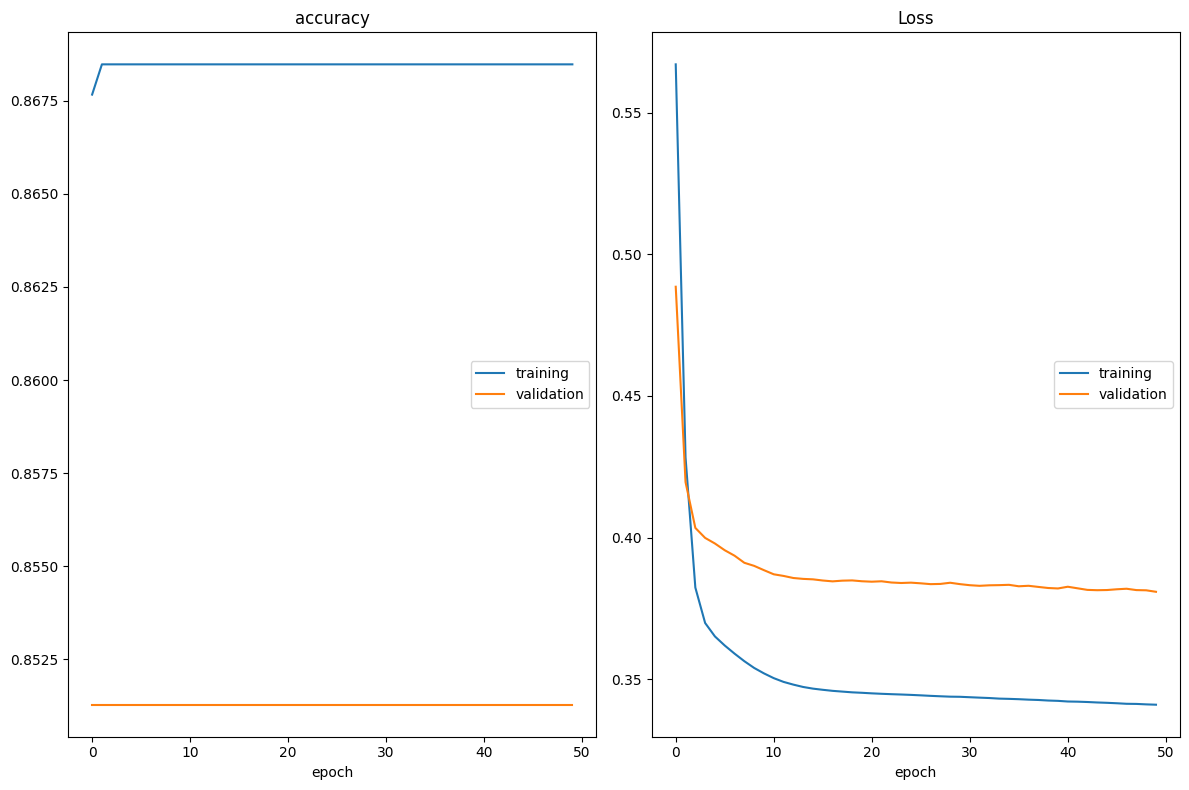

accuracy
	training         	 (min:    0.868, max:    0.868, cur:    0.868)
	validation       	 (min:    0.851, max:    0.851, cur:    0.851)
Loss
	training         	 (min:    0.341, max:    0.567, cur:    0.341)
	validation       	 (min:    0.381, max:    0.489, cur:    0.381)
104/104 [==============================] - 8s 80ms/step - loss: 0.3410 - accuracy: 0.8685 - val_loss: 0.3808 - val_accuracy: 0.8513


In [ ]:
model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
          epochs=50,
          callbacks=[PlotLossesKeras()])

What does the cost function behavior mean over the traning in the above plot?

---

# Your Turn!

## Hands On - Keras Fully Connected


Take couple of minutes and try to play with the number of layers and the number of parameters in the layers to get the best results.

In [ ]:
K.clear_session()
print("Building model...")
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()


In [ ]:
model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
          epochs=50,
          callbacks=[PlotLossesKeras()])